## Jump Straight to Our Code

The sections above our code are all containing template code.

[Click me](#Our-Code) to get straight to our implementation.

## Simulating traffic with Monte Carlo chains 


For each car we associate a vector which a number of elements that corresponds to the total number of steps we will consider at the most. At each time step we will record where the car is. We denote this by $t_M$, while each time step will be denoted as $t_m$.  

If the car is not in the system yet, it will be notes as position 0. If the car is out of a circuit which as $N$ positions, then it will be set at position $N+1$. 
We also consider a maximum number of cars given by $N_C$.  

So the overall dynamics can be recorded in a matrix of dimension $t_M\times N_C$. We will call this the matrix of histories $H$. 
    

Position 0 corresponds to car not yet in the system 

#### Dynamics   

Given a position in the network, we need to know which are the possible other locations in which a car can move from there. We refer to this as the connectivity matrix $C$. 

Given any entrance point we will check whether a new car is entering the system 


#### What information do we want to get? 

For each car, we would like to compute the average time it takes to go from the first position to the exit, and the standard deviation. 

Then we would also like to compute what is average time for which it stays in one position, and the standard deviation. 
We can also try to figure which areas are most congested, i.e. cars tend to spend more time at. 

Given a roads network in which a car can go from entrance to exit following different paths, it could be interesting to find out which path is faster.    

Another useful piece of information?    

If you think about it, it is possible to gather this information from the matrix of histories $H$. 

#### We are going to first consider a simple straight road 

The road as $4$ locations in which a car can be, one entrance at position $1$ and one exit just after position $4$. 
From position $1$ you can only fo to position $2$, from $2$ you can only go $3$, from $3$ to $4$, and from $4$ to exit. 
We will also consider that each car move as soon as the position in which it wants to go is free. 




#### Some possible variations 

Add the possibility that a car sits where it is, for a while, for whatever reason (a measure of its velocity). Or add the possibility that the car goes at half the speed, e.g. it moves once every two time steps. 

For each car we associate some properties: velocity, probability of flowing, probability of getting into an accident (e.g. from moving into a location despite a car already stays there), effect of accident (e.g. freeze the cars involved in the accident for a number of time steps and then remove them from the system).     

#### Probability of moving forward 

Here we still consider the simple case of a straight road in which, however, each car does not move at a constant speed, but it has a fluctuating speed. Sometimes it moves a little faster and sometimes a little slower. 
For example we associate to each car a probability of moving, or of staying where it is. 

We will first consider the case in which this probability is the same for everyone, later we can try to have a different probability for each car.      


#### Junctions     

Junctions can increase the possible positions in which a car can choose to go, and they can also lead more cars to the same position, does generating possible congestions.           

To model junctions we can do this:   
- if a car can go in more than one place, we can randomly pick where it is going 
- then we get an updated position of cars 
- but if more than 1 car is in the same position, we randomly pick which car actually moves in that position, while the others revert to the position in which they were previously 

Possible improvements consists in giving priorities to cars coming from different directions, or adding traffic lights. How would you model these scenarios? 


#### Addition of another entrance 

At a different location from position $0$, it is possible to add another entrance. Similar to the main entrance, a car can enter the system following a probability distribution. 

But whether the car is actually really entering the system or not will be sorted out as for any other junctions via the step of removal of conflicts. 

#### Considering a more complex street network 

Try now to design a different network, ask yourself some questions, and see what answers you get :-))   


### What we use 

In [2]:
using Plots, Statistics, Random, StatsBase, DelimitedFiles, WebIO

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-9216329938672017973\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15920913121658946875\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-9216329938672017973\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Simple example of a straight road 

We will consider the following assumptions 
- the car will move if they can 
- there are $N$ positions, one directly connected to the next from entrance to exit 




#### Function that makes the connectivity matrix (tested) 
Return a connectivity matrix, $C$, that represents a straight road of length $L$. In addition to the entrance at position 1 and exit at position 15, there is another entrance at position 5

In [3]:
function connect_matrix_straight(L)
    # we build a connectivity matrix. Although for a straight line a vector would suffice, to make it easier to generalize later, we use a matrix 
    C = zeros(Bool,L+2,L+2);
    for i = 1:L+1
        C[i,i+1]=1;
    end
    C[L+2,L+2] = 1; 
    C[1,4] = 1; #extra entrance
    return C
end


connect_matrix_straight (generic function with 1 method)

#### Function that initializes the matrix of histories (tested)
Entries of history marix, $H$, are initialized to 0. All cars get ready at position 0. This matrix stores the trajectory of the cars. Each row corresponds to a car in the system and each column stores the position of all the car at a snapshot in time

In [4]:
function initialize_H(tM, NC)
    # tM maximum number of time steps
    # NC is the number of cars
    return H = zeros(Int16,NC, tM+2);
end

initialize_H (generic function with 1 method)

#### Function that finds available next positions (tested) 
Given a car's position (for example, ip), following procedure are used to determine the available positions
1. Determine the **reachable positions** by inspecting the corresponding row of the connectivity matrix, $C$
1. Determine the **occupied positions** by inspecting the column of history matrix, $H$, corresponds to the time step. However, 0 and L+1 are excluded. Recall that these two positions are positions which host the awaiting and terminated cars respectively. 
1. **Positions available** are the positions which are reachable but not occupied. Equivalently, set of reachable subtract set of occupied.

In [5]:
function find_pos_available1(ic, it, H, C, L) 
    # ic is the car number 
    # it is the time step 
    # H matrix of histories 
    # C connectivity matrix 
    # L is the number of positions 
    
    aux = size(H);
    NC = copy(aux[1]);
    vec_pos0 = Int64.(zeros(0));
    vec_pos = Int64.(zeros(0)); 
    ip = copy(H[ic,it]); #position of the car   
    for iL = 1:L+2
        if C[ip+1,iL] == 1
            vec_pos0 = append!(vec_pos0, iL-1);
        end
    end
    aux = size(vec_pos0)
    for ipos = 1:aux[1]
        s=0;
        if vec_pos0[ipos] != L+1 #unless the car is outside, position L+1      
            for iNC = 1:NC
                if H[iNC,it] == copy(vec_pos0[ipos]);
                    s+=1;
                end
            end
        end    
        if s==0
            vec_pos = append!(vec_pos,vec_pos0[ipos]);
        end
    end
    return vec_pos
end

find_pos_available1 (generic function with 1 method)

In [6]:
function find_pos_available2(ic, it, H, C, L) 
    # ic is the car number 
    # it is the time step 
    # H matrix of histories 
    # C connectivity matrix 
    # L is the number of positions 
    ip = copy(H[ic,it]); #position of the car 
    # indices of '1' entries, subarray start from 2, no need to minus 1
    reachable=findall(x->x==1,C[ip+1,2:end]) 
    # a list of occupied position excluding 0 and L+1
    occupied=filter(x-> x>0 && x<L+1,H[:,it])
    # available positions are reachable - occupied
    return setdiff(reachable,occupied)
end

find_pos_available2 (generic function with 1 method)

#### Function that moves a single car (tested) 
A car first decides whether to move according to the dictated probability. If so, it randomly picks one position from available positions and registers the intention into the corresponding column of history matrix, $H$. Note that, at this stage, the movement is not final due to possible conflicts with other cars. 

In [7]:
function move_car(ic,it,H,C, L, p_mov)
    # ic is the car number
    # H matrix of histories
    # it time step
    # C connectivity matrix
    # p_mov is the probability to move
    H[ic, it+1] = copy(H[ic, it]); 
    vec_pos = find_pos_available(ic, it, H, C,L);
    aux = size(vec_pos);
    n_pos = copy(aux[1]);
    if n_pos>0
        r = rand(1);
        if r[1]<p_mov
            i_pos = rand(1:n_pos,1,1);
            H[ic, it+1] = copy(vec_pos[i_pos[1]]); 
        end
    end
    return H
end

move_car (generic function with 1 method)

#### Check for and resolve conflicts (tested) 

Given a position in the traffic network, following procedure is used to resolve conflicts:
1. Determine a list of cars going to the same position by inspecting the column of history matrix, $H$, correspond to current time step. For example, given it (time step) and iL (position in traffic network), the index of entries in H[:,it]==iL are the cars which are going into iL.
1. More than 1 cars going into the same position constitue a conflict
1. To resolve conflict, we randomly let one car to move on and make the rest stay put
1. Iterate over all positions in the traffic network, rinse and repeat

In [8]:
function find_resolve_conflicts1(H, L, it)
    # it is the time step 
    # H matrix of histories 
    # L is the number of positions 
    Hn = copy(H); 
    aux = size(H); 
    NC = aux[1]; 
    for iL = 1:L
        list_cars = Int64.(zeros(0)); 
        for ic = 1:NC 
            if H[ic,it] == iL 
                list_cars = append!(list_cars, ic);
            end
        end
        aux = size(list_cars); 
        if aux[1]>1
            i_pos = rand(1:aux[1],1,1);
            keep_pos = copy(i_pos[1]); 
            for ipos = 1:aux[1]
                Hn[list_cars[ipos], it] = copy(H[list_cars[ipos], it-1]);
            end
            Hn[list_cars[keep_pos], it] = copy(H[list_cars[keep_pos], it]);
        end
    end
    return Hn 
end

find_resolve_conflicts1 (generic function with 1 method)

In [9]:
function find_resolve_conflicts2(H, L, it) 
    # it is the time step 
    # H matrix of histories 
    # L is the number of positions 
    Hn = copy(H); 
    for iL = 1:L
        list_cars=findall(x->x==iL,H[:,it])
        if length(list_cars)>1
            shuffle!(list_cars)            
            Hn[list_cars,it]=copy(H[list_cars,it-1])
            Hn[list_cars[1], it] = copy(H[list_cars[1], it]);
        end
    end
    return Hn 
end 

find_resolve_conflicts2 (generic function with 1 method)

#### Function that moves all the cars (tested) 
All cars try to move and conflicts are resolved, the movements are final.

In [10]:
function next_step(H, p_mov, it, C, L)
    # H matrix of histories
    # p_inj probability of injecting
    # p_mov probability of moving
    # it time step
    # C connectivity matrix
    aux = size(H);
    NC = copy(aux[1]); 
    for ic = 1:NC
         H = move_car(ic,it,H,C, L, p_mov); # this function moves a car
    end
    H = find_resolve_conflicts(H, L, it+1); # this function finds and resolves conflicts -> to be done
    return H
end

next_step (generic function with 1 method)

#### Site numbering scheme

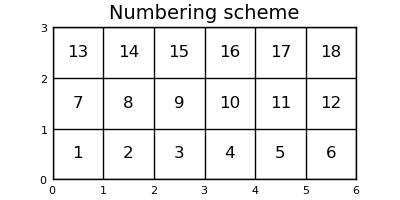

In [11]:
nCol,nRow=6,3
expand=(x)->((x-1) % nCol + 0.5,(x-1) ÷ nCol + 0.5, "$(x)" )
annot=[expand(i) for i in 1:nCol*nRow]
pyplot(size=(400,200))
plot(xlim=(0,nCol), xticks=[0:nCol;],
    ylim=(0,nRow),yticks=[0:nRow;],
    title="Numbering scheme",
    legend=false,aspect_ratio=:equal,framestyle=:box,
    grid=true,foreground_color_grid=:black,gridalpha=1,gridlinewidth=1,
    annotation = annot,annotationfontsize=12)

#### Plot traffic map on 2D grid
The function plotMapFromConnectivity do the followings:
1. Draw 2D grid of given number of rows and columns
1. Label unreachable cells with black   (columns of $C$ with all zeros)
1. Label entry cell with green and text (inferred from 1st row of $C$)
1. Label exit cell with red and text (inferred from last colum of $C$)
1. Label connectivity bewteen cells with arrows (inferred from rows of $C$)
1. Draw hostpot if specified (output of function congest_plot further below)

In [12]:
function plotMapFromConnectivity(C,nCol,nRow;hotspot=nothing)
    # C is the connectivity matrix
    # nCol is the number of columns
    # nRow is the number of rows
    # hotspot, a keyword argument, is the congested spot which default to nothing
    
    # rectrangular patch
    rect(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
    # convert 1D to 2D index
    getXY= (x) -> ((x.-1) .% nCol .+ 1,(x.-1) .÷ nCol .+ 1 ) ;
    
    plot(xlim=(0,nCol), xticks=[0:nCol;],ylim=(0,nRow),yticks=[0:nRow;],
        legend=false,aspect_ratio=:equal,framestyle=:box,
        grid=true,foreground_color_grid=:black,gridalpha=1,gridlinewidth=1)
    
#     unreachable cells: black
    s=dropdims(sum(C[1:end-1,2:end-1],dims=1),dims=1)
    for i in findall(x->x==0,s)
        x,y=getXY(i)
        plot!(rect(1,1,x-1,y-1),color=:black)
    end
    
#     entry sites: transparent green
    entries=findall(x->x==1,C[1,:])
    for i in entries
        x,y=getXY(i-1)
        plot!(rect(1,1,x-1,y-1),color=:green,opacity=0.2,
            annotation = [(x-0.5, y-0.2, "entry")],annotationfontsize=8)
    end   
    
#     exit sites: transparent red
    exits=findall(x->x==1,C[2:end-1,end])
    for i in exits
        x,y=getXY(i)
        plot!(rect(1,1,x-1,y-1),color=:red,opacity=0.2,
            annotation = [(x-0.5, y-0.8, "exit")],annotationfontsize=8)
    end

#  connected site: arrow   
    s=dropdims(sum(C[2:end-1,2:end-1],dims=2),dims=2)    
    for r in findall(x->x>0,s)
        reachable=findall(x->x==1,C[r+1,2:end-1])
        x0,y0=getXY(r) 
        x1,y1=getXY(reachable)
        dx,dy=x1.-x0,y1.-y0;
        quiver!([x0-0.5].+0.25.*dx,[y0-0.5].+0.25.*dy,
                quiver=((dx.*0.5,dy.*0.5)),color=:black)
    end
    
#  hotspot: dotted outline
    if !isnothing(hotspot)
        for i in hotspot
            x,y=getXY(i)
            plot!([x-1,x-1,x,x,x-1],[y-1,y,y,y-1,y-1],color=:red,linewidth=3,linestyle=:dot)
        end
    end
    return current()
end

plotMapFromConnectivity (generic function with 1 method)

#### Show positions of all cars at one time instant
Cars are labelled with circles annotated with ID, newly injected car is labelled with diamond

In [13]:
function plotAllCarAtOneInstant1(H,t,nCol,nRow;c=palette(:tab10))
    # H is the history matrix
    # t is time step
    # nCol is the number of columns
    # nRow is the number of rows
    # c, a keyword argument, is the color palette which default to tab10
    pos=H[:,t];
    maxNodes=nCol*nRow;
    getXY(x) = ((x-1) % nCol + 1,(x-1) ÷ nCol + 1 ) ;
    l=length(c)
    plot!(title="t=$(t-1)")
    for id= 1:length(pos)
        p=pos[id];
        if p==0 || p>maxNodes continue; end        
        x,y=getXY(pos[id])
        shape=:circle;
        if t>0 && H[id,t-1]==0  shape=:diamond; end
        scatter!([x-0.5],[y-0.5],color=c[(id-1)%l+1],
            annotation = [(x-0.5, y-0.5, "$(id)")],annotationfontsize=9,
            markershape=shape, markersize=16,
            markerstrokestyle=:dot,markerstrokewidth=2)
    end
    return current()
end

plotAllCarAtOneInstant1 (generic function with 1 method)

In [14]:
function plotAllCarAtOneInstant2(H,t,nCol,nRow;c=palette(:tab10))
    # H is the history matrix
    # t is time step
    # nCol is the number of columns
    # nRow is the number of rows
    # c, a keyword argument, is the color palette which default to tab10
    pos=H[:,t];
    maxNodes=nCol*nRow;
    getXY= (x) -> ((x.-1) .% nCol .+ 1,(x.-1) .÷ nCol .+ 1 ) ;    
    
    id=findall(x->x>0 && x<=maxNodes,pos);
    x,y=getXY(pos[id]);
    annot=[(xx-0.5,yy-0.5,"$(i)") for (i,xx,yy) in zip(id,x,y)];
    shape=[:circle for i in id];
    (t>1) && (shape[H[id,t-1].==0].=:diamond);
    
    return scatter!(x.-0.5,y.-0.5,color=c[(id.-1).%length(c).+1],
                    title="t=$(t-1)",
                    annotation = annot, annotationfontsize=9,
                    markershape=shape, markersize=16, markerstrokewidth=2)
end

plotAllCarAtOneInstant2 (generic function with 1 method)

#### Animate whole history
Go through the whole time history and plot trajectories of all cars. Essentially, plotAllCarAtOneInstant is called in a loop, refer to plotAllCarAtOneInstant for details.

In [15]:
function plotHistory(H,C,nCol,nRow;delay=0.5,hotspot=nothing)
    # H is the history matrix
    # C is the connectivity matrix
    # nCol is the number of columns
    # nRow is the number of rows
    # delay, a keyword argument, is the pause between frame which default to 0.5s
    # hotspot, a keyword argument, is the congested spot which default to nothing
    nCar,tMax=size(H);
    tMax=min(tMax,tMax-sum(sum(H.==nCol*nRow+1,dims=1).==nCar)+1);
    pmap=plotMapFromConnectivity(C,nCol,nRow,hotspot=hotspot);
    for i=1:tMax
        IJulia.clear_output(true)
        plot(deepcopy(pmap))
        plotAllCarAtOneInstant(H,i,nCol,nRow);
        display(current())
        sleep(delay)
    end
    IJulia.clear_output(true)
    return
end

plotHistory (generic function with 1 method)

#### Analayze the congestion 
Based on the history matrix, $H$, we count how many halts happen at each position and visualize the distribution using a histogram. The function also determine the most congested spot in the traffic network.

In [16]:
function congest_plot1(H,a,b,L)
    ## H is the history matrix
    # a is the starting time chosen to check congestion
    # b is the final time
    # L is the number of sites
    sv = size(H);
    c = Int64[];
    cp = Int64[];
    
    for i in 1:sv[1]
        k=0;
        for j in a:b-1
           if(H[i,j] == H[i,j+1]) # here it is checked whether the car was halted at the next time step
               append!(c,H[i,j]) # if yes we count the position in c array
           end
        end
    end
    
    c = filter(x-> x != 0, c)  # this is used to filter the zero value meaning car is not entered the road 
    c = filter(x-> x != L+1, c) # this is used to filter the final value meaning car is exited from the road
    display(histogram(c,nbins=L+1, title = "Congestion plot from time t=$a to t=$b", 
            xlabel = "Position", ylabel = "Number of cars halted",legend=false,titlefontsize=12))
    
    for k in 1:L
    cp = append!(cp,count(m -> (m == k), c)) #cp stores the time steps car is stopped at a position in ascending order
    end
    
    x_p = maximum(cp)
    x_point=findall(m -> (m == x_p), cp) # position at which maximum number of car halts
    println("The maximum congetsion is at position $x_point during the time t=$a to t=$b")
    return x_point
end

congest_plot1 (generic function with 1 method)

In [17]:
function congest_plot2(H,a,b,L)
    ## H is the history matrix
    # a is the starting time chosen to check congestion
    # b is the final time
    # L is the number of sites
    
    counter=zeros(Int64,L) # the histogram 
    
    # use run length encoding to count
    for row in eachrow(H[:,a:b])
        p=filter(x-> x>0 && x<=L,row)
        for (k,l) in zip(rle(p)...) # run length
            counter[k]+= l-1 #do not count the first occurence
        end
    end    
    
    # implementation 2: only traverse H once
#     for row in eachrow(H[:,a:b])
#         iter = Iterators.filter(x-> x>0 && x<=L,row)
#         (item1, state) = iterate(iter)
#         while (iter2=iterate(iter, state)) != nothing
#             (item2, state) = iter2        
#             item1==item2 && (counter[item1]+=1)
#             item1=item2
#         end
#     end
    
    x_point=findall(x->x==maximum(counter),counter)
    
    display(bar(counter,bar_edges=true,bar_width=1,xticks=[1:L;],
                title = "Congestion plot from time t=$a to t=$b", 
                xlabel = "Position", ylabel = "Number of cars halted",
                legend=false,titlefontsize=12))
        
    println("The maximum congetsion is at position $x_point during the time t=$a to t=$b")
    return x_point
end

congest_plot2 (generic function with 1 method)

#### Analyze the time spent travelling between point a and b
For each car, we determine the time spent to get from point a to point b. The distribution is visualized using histogram. Following that, average and standard deviation of time spent are reported in stdout

In [18]:
function time_taken1(H, a, b)
    # calculate the time taken by each car from positon a to position b given the history matrix
    # H history matrix
    # a start position
    # b final position
    # tt is the vector that stores the time taken to go from a to b by each car
    sv = size(H);
    tt = Int64[];
    tn = Int64[]; 
    kn=0;kb=0;ka=0;
    
    for  i in 1:sv[1]
    n_posa = 0;
    n_posb = 0;
        for j in 1:sv[2]
            if (n_posa < 1)
                if (H[i,j] == a) #here when the position of car is"a", then time is written in ka
                    ka = j
                    n_posa = 1;
                 end
             end
            if (n_posb < 1)
                 if (H[i,j] == b) #here when the  position of car is"b", then time is written in kb
                    kb = j
                    n_posb = 1;
                 end
            end
                 
         end
        
         if (n_posa ==1 && n_posb == 1) # this filters any cars that doesn't pass through both points a and b
            kn=kn+1
            append!(tt,kb-ka)
            append!(tn,i)
         end
    end
    #println(tt)
    display(histogram(tt, nbins=abs(b-a), title = "Time taken to travel from $a to $b", 
            xlabel = "Time taken", ylabel = "Number of cars",legend=false,titlefontsize=12)) 
   
    t_avg = mean(tt)
    t_sd = var(tt)
    println("The average time taken by cars to travel from position $a to $b is $t_avg ")
    println("The standard deviation of the time taken by cars to travel from $a to $b is $t_sd ")
    return 
end 

time_taken1 (generic function with 1 method)

In [19]:
function time_taken2(H, a, b)
    # calculate the time taken by each car from positon a to position b given the history matrix
    # H history matrix
    # a start position
    # b final position
    # tt is the vector that stores the time taken to go from a to b by each car
   
    tt=Int64[]
    for row in eachrow(H)
        (i_a=findfirst(x->x==a,row)) == nothing && continue;
        (i_b=findnext(x->x==b,row,i_a+1)) == nothing && continue;
        append!(tt,i_b-i_a)
    end

    display(histogram(tt, nbins=abs(b-a), 
            title = "Time taken to travel from $a to $b", 
            xlabel = "Time taken", ylabel = "Number of cars",
            legend=false,titlefontsize=12)) 
   
    println("The average time taken by cars to travel from position $a to $b is $(mean(tt)) ")
    println("The standard deviation of the time taken by cars to travel from $a to $b is $(var(tt)) ")
    return 
end 

time_taken2 (generic function with 1 method)

In [20]:
function readConnectivity(filename)
    return readdlm(filename, ',',Bool);
end

readConnectivity (generic function with 1 method)

#### Allow to switch implementation

In [21]:
find_pos_available=find_pos_available2;
find_resolve_conflicts=find_resolve_conflicts2;
time_taken=time_taken2;
congest_plot=congest_plot2;
plotAllCarAtOneInstant=plotAllCarAtOneInstant2;

# Our Code

Aim: Compare the congestion in:

- Scenario 1: Straight Road
- Scenario 2: Straight Road + Side Road
- Scenario 3: Straight Road + Side Road + Traffic Lights


## Side Road

Introduce a side road which intersects the main road at ```junction``` and the exit point.

Aim: Divide traffic flow to minimise congestion in the main road.

Con: A junction is introduced where there is a higher probability of cars colliding.

## Traffic Light

Introduce artificial congestions temporarily (from time i to time j) to the node that is at the position of ```junction-1```. This is done by reducing the speed of the car (```p_mov```) to ```0.0``` at those nodes.

Aim: Reduce the probability of congestion as collision is minimised when cars from either side of a junction take turns to move.

Con: By stopping a car before a junction, a mini congestion is created before the traffic light.

Note: Traffic lights will not be placed at the junction node in order to allow for the other traffic flow to continue, and it will not be placed at ```junction+1``` in order to prevent collision.

In [22]:
# Create 2D Connectivity Matrix to simulate roads with side roads
function c_matrix_2d(L)
    # NOTE: When comparing between road with side roads vs linear roads, the main road must be of the same length
    #=
    L = total number of nodes
    e.g. L = 8
      []
    [][][][][][] main road
      []
    =#
    C = zeros(Int64, L+2, L+2)
    
    C[1, 8] = 1
    C[8, 9] = 1
    C[9, 10] = 1
    C[10, 11] = 1
    C[11, 12] = 1
    C[12, 13] = 1
    C[13, 20] = 1
    C[20, 20] = 1
    C[1, 4] = 1
    C[4, 10] = 1
    C[10, 16] = 1
    C[16, 17] = 1
    C[17, 18] = 1
    C[18, 12] = 1
    
    return C
end

c_matrix_2d (generic function with 1 method)

In [23]:
function traffic_light(C, H, junction, car_speeds, time, route)    
    # route == 0 -> main road
    # route == 1 -> side road
    new_speeds = copy(car_speeds)
    car_count, time_stamp_count = size(H) # time_stamp_count is not used
    for car = 1:car_count
        node = H[car, time]
        if route == 0
            if node == 9 || node == 11 # placed on main road before each junction
                new_speeds[car, 1] = 0
            end
        else
            if node == 4 || node == 18 # placed on side road before each junction
                new_speeds[car, 1] = 0
            end
        end
    end
    return new_speeds
end

traffic_light (generic function with 1 method)

In [24]:
# Initialisation

NC = 10 # number of cars
tM = 55 # total time steps
p_mov = 0.5 # probability of moving

H = initialize_H(tM, NC)

10×57 Matrix{Int16}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

## Scenario 1: Straight Road

In [25]:
L_main = 6 # number of nodes

C = connect_matrix_straight(L_main)

H1 = copy(H)

for it = 1:tM+1
    H1 = next_step(H1, p_mov, it, C, L_main)
end

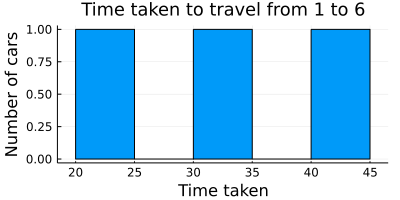

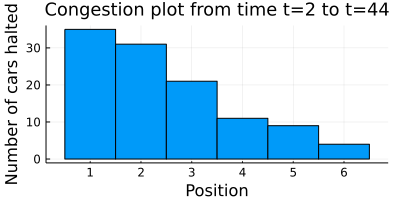

The average time taken by cars to travel from position 1 to 6 is 31.666666666666668 
The standard deviation of the time taken by cars to travel from 1 to 6 is 114.33333333333333 
The maximum congetsion is at position [1] during the time t=2 to t=44


1-element Vector{Int64}:
 1

In [26]:
a = 1
b = 6
t1 = 2
t2 = 44
gr(size=(400,200))
ttime = time_taken(H1, a, b)
ct = congest_plot(H1,t1,t2,L_main)

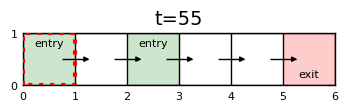

In [27]:
pyplot(size=(750,100))
nCol,nRow=L_main,1
plotHistory(H1,C,nCol,nRow;delay=0.1,hotspot=ct)

## Scenario 2: Straight Road + Side Road

In [28]:
L = 18
C = c_matrix_2d(L)

H2 = copy(H)

for it = 1:tM+1
    H2 = next_step(H2, p_mov, it, C, L);
end

car_speeds = zeros(Float64, NC, 1)
for row = 1:NC
    car_speeds[row, 1] = p_mov # Assuming that cars move at the same speed
end

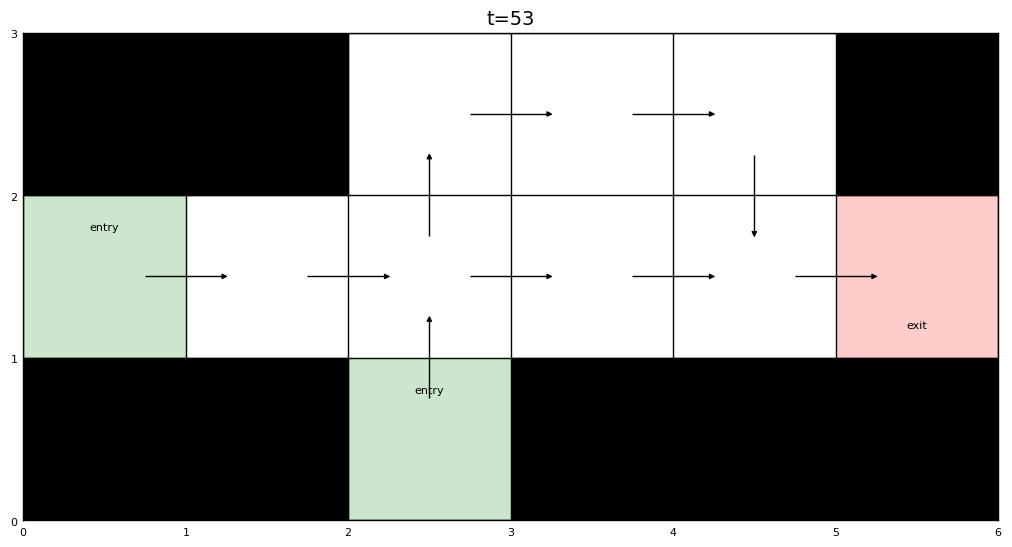

In [29]:
pyplot(size=(1000,1000))
nCol,nRow=6,3
plotHistory(H2,C,nCol,nRow;delay=0.1)

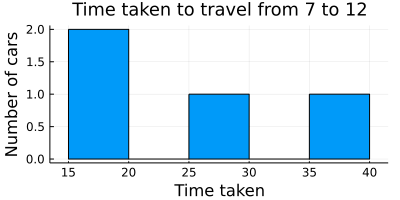

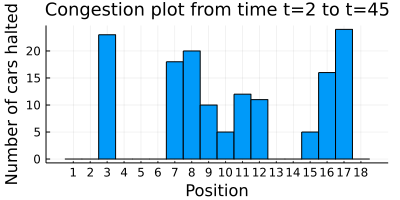

The average time taken by cars to travel from position 7 to 12 is 24.25 
The standard deviation of the time taken by cars to travel from 7 to 12 is 112.91666666666667 
The maximum congetsion is at position [17] during the time t=2 to t=45


1-element Vector{Int64}:
 17

In [30]:
a = 7
b = 12
t1 = 2
t2 = 45
gr(size=(400,200))
ttime = time_taken(H2, a, b)
ct = congest_plot(H2,t1,t2,L)

## Scenario 3: Straight Road + Side Road + Traffic Light

In [37]:
L = 18
C = c_matrix_2d(L)

H3 = copy(H)

for it = 1:tM+1
    H3 = next_step(H3, p_mov, it, C, L);
end

car_speeds = zeros(Float64, NC, 1)
for row = 1:NC
    car_speeds[row, 1] = p_mov # Assuming that cars move at the same speed
end

for time=1:tM
    row_num, column_num = size(C)
    for node = 1:column_num
        if node == 10 || node == 12
            traffic_light(C, H3, node, car_speeds, time, time%2) # time%2 is implemented to switch between main and side traffic light
        end
    end
end

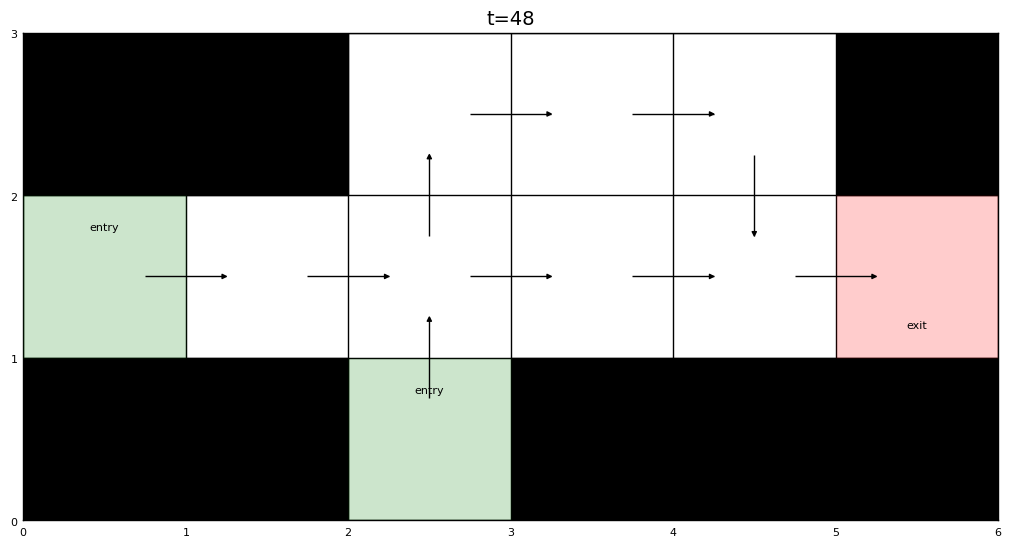

In [38]:
pyplot(size=(1000,1000))
nCol,nRow=6,3
plotHistory(H3,C,nCol,nRow;delay=0.1)

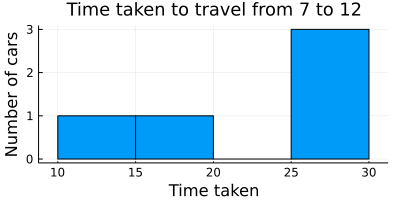

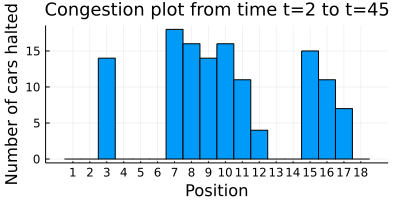

The average time taken by cars to travel from position 7 to 12 is 22.4 
The standard deviation of the time taken by cars to travel from 7 to 12 is 53.80000000000001 
The maximum congetsion is at position [7] during the time t=2 to t=45


1-element Vector{Int64}:
 7

In [39]:
a = 7
b = 12
t1 = 2
t2 = 45
gr(size=(400,200))
ttime = time_taken(H3, a, b)
ct = congest_plot(H3,t1,t2,L)